In [33]:
import pandas as pd
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
%matplotlib inline
pd.set_option('display.max_rows', None) # or 1000.

In [16]:
from dotenv import dotenv_values
config = dotenv_values("../.env")

In [17]:
config

OrderedDict([('DBNAME', 'adsdb'),
             ('USER', 'postgres'),
             ('PASSWORD', 'postgresadmin'),
             ('SCHEMA', 'formatted')])

In [18]:
conn = psycopg2.connect(dbname=config['DBNAME'], user=config['USER'], password=config['PASSWORD'])

In [19]:
df_tables = pd.read_sql('SELECT table_name FROM information_schema.tables WHERE table_schema=\'' + config['SCHEMA'] +'\'   AND table_type=\'BASE TABLE\';', conn)
df_tables

,table_name
0,morticd_10_1_f695_1642950107
1,morticd_10_3_1c6a_1642928618
2,morticd_10_4_453e_1642928618
3,notes_0_a67b_1642928619
4,population_0_3b8f_1642928619
5,demographiccountry_0_e0e0_1642950106
6,demographic_0_76f7_1642950106
7,demographiclabels_0_e8a5_1642950107
8,morticd_7_22b4_1642950107
9,morticd_8_9366_1642950107


In [20]:
max_timestamp = df_tables['table_name'].apply(lambda x: x[x.rfind('_') +1 :-2]).max()
max_timestamp

'16429501'

In [21]:
df_lastupdate_tables = df_tables['table_name'].apply(lambda x: max_timestamp in x)
df_tables[df_lastupdate_tables]

,table_name
0,morticd_10_1_f695_1642950107
5,demographiccountry_0_e0e0_1642950106
6,demographic_0_76f7_1642950106
7,demographiclabels_0_e8a5_1642950107
8,morticd_7_22b4_1642950107
9,morticd_8_9366_1642950107
10,morticd_9_71c9_1642950107
11,morticd_10_2_ffb1_1642950108
12,morticd_10_3_1c6a_1642950108
13,morticd_10_4_453e_1642950109


In [22]:
mortic_dataframes = []
demo_dataframes = []
general_dataframes = []
for table in df_tables[df_lastupdate_tables]['table_name']:
    firstDash = str(table).index('_', 0)
    lastDash = str(table).rindex('_')
    secondlastDash = str(table).rindex('_', lastDash)
    dfname = str(table[:secondlastDash])
    if  dfname.count('_') >= 2:
        lastDash = dfname.rindex('_')
        dfname = dfname[:lastDash]
    if 'morticd' in dfname:
        mortic_dataframes.append('df_' + dfname)
    elif 'demo' in dfname:
        demo_dataframes.append('df_' + dfname)
    else:
        general_dataframes.append('df_' + dfname)
    globals()['df_' + dfname] = pd.read_sql('SELECT * from ' + config['SCHEMA'] + '.' + table + ';', conn)

In [23]:
demo_dataframes

['df_demographiccountry_0', 'df_demographic_0', 'df_demographiclabels_0']

In [24]:
mortic_dataframes

['df_morticd_10_1',
 'df_morticd_7',
 'df_morticd_8',
 'df_morticd_9',
 'df_morticd_10_2',
 'df_morticd_10_3',
 'df_morticd_10_4']

In [25]:
general_dataframes

['df_countrycodes_0', 'df_notes_0', 'df_population_0']

### Correlation matrix

df_morticd_10_1


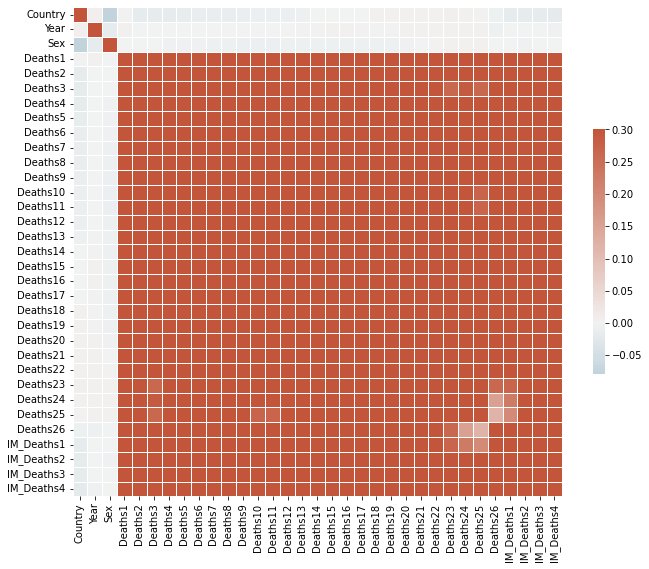

df_morticd_7


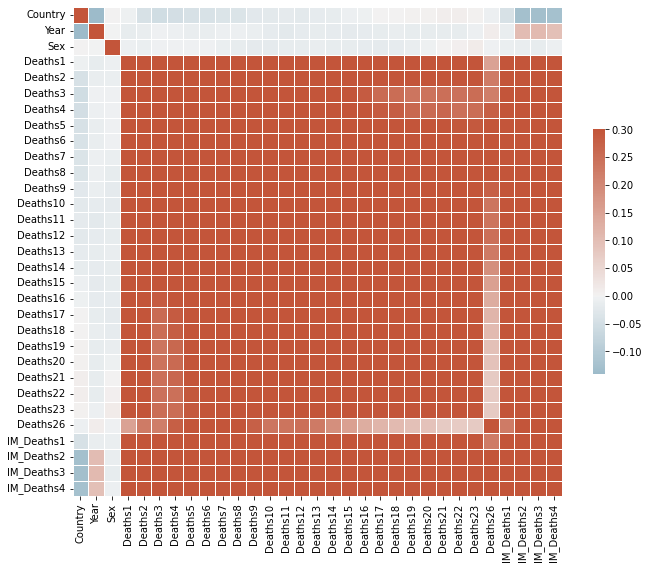

In [27]:
for mortic_dataframe in mortic_dataframes:
    print(str(mortic_dataframe))
    df_num = globals()[str(mortic_dataframe)].select_dtypes(include=np.number)
    corr = df_num.corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

### General profiling

In [29]:
# Get Demographic Indicators
def getDemoInddf():
    for name in globals().keys():
        if 'df_demographic_' in name: 
            return name

df_demo_indic = getDemoInddf()
df_demo_indic

'df_demographic_0'

df_demographic_0


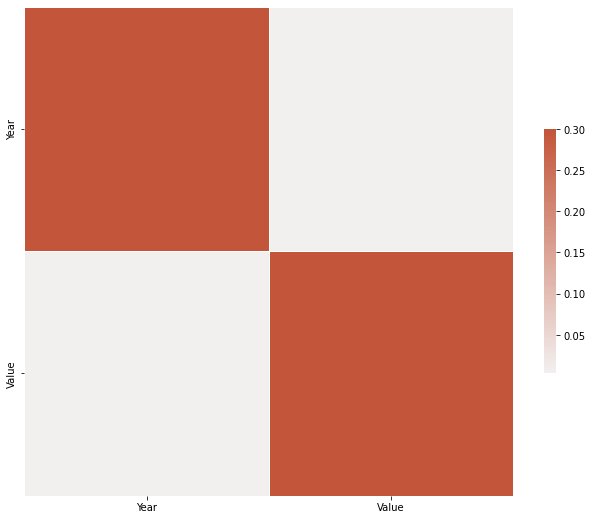

In [30]:
print(str(df_demo_indic))
df_num = globals()[str(df_demo_indic)].select_dtypes(include=np.number)
corr = df_num.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [36]:
mortic_dataframes[0:1]

['df_morticd_10_1']

In [46]:
profile_test = pandas_profiling.ProfileReport(df_morticd_10_1, minimal=True)
profile_test.to_file(output_file= "test.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


In [48]:
profiles =[]
for mortic_dataframe in mortic_dataframes:
    profile = pandas_profiling.ProfileReport(globals()[str(mortic_dataframe)], minimal=True)
    profiles.append(mortic_dataframe + ".html")
    profile.to_file(output_file = str(mortic_dataframe) + ".html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 165.85it/s]
